# KIV/OPIS Oborový projekt IS

## Příprava dat

Načteme soubor s daty z klinické studie srdečních nemocí.

In [0]:
import pandas as pd
import time

t = time.time()
df = pd.read_excel('fmpl-sits-dataset.xlsx', sheet_name='all', header=8, index_col=None, na_values=['NA'], usecols='B:C,E:BY')
elapsed = time.time() - t

print('Excel load time: {:.2f} seconds'.format(elapsed))
print('Number of rows: {}'.format(df.shape[0]))

Excel load time: 34.53 seconds
Number of rows: 2890


Do proměnných uložím názvy sloupců, se kterými budu pracovat.
Jedná se o názvy sloupců z datasetu, ale i o nové názvy sloupců, které budu teprve vytvářet.

In [0]:
# General
AGE = 'age'
SEX = 'sex'
BMI = 'BMI'
HEIGHT = 'heightvalue'
WEIGHT = 'weight'
NIHSS = 'NIHSS baseline'
NIHSS_DISCHARGE = 'NIHSS-diff-discharge'
TROMBECTOMY = 'thrombectomyDone'
TROMBOLYSIS = 'thrombolysisIV'
TREATMENT = 'treatment'

GEN_LIST = [AGE, SEX, HEIGHT, WEIGHT, NIHSS_DISCHARGE]

# Diagnosis
BOOL_VTA = 'involvedVascularTerritorryArterior'
BOOL_VTL = 'involvedVascularTerritorryLeft'
BOOL_VTP = 'involvedVascularTerritorryPosterior'
BOOL_VTR = 'involvedVascularTerritorryRight'
BOOL_VTU = 'involvedVascularTerritorryUnknown'
BOOL_AFB = 'atrialFibrilation'
BOOL_CHF = 'congestiveHeartFailure'
BOOL_DIA = 'diabetes'
BOOL_HYL = 'hyperlipidemia'
BOOL_HYT = 'hypertension'
BOOL_SEM = 'previousStrokeEarlierThan3M'
BOOL_SWM = 'previousStrokeWithin3M'
BOOL_PTA = 'previousTIAOrAmaurosis'
BOOL_SC = 'smokerCurrent'
BOOL_SP = 'smokerPrevious'
BOOL_VD = 'vascularDisease'

DIAG_LIST = [
    BOOL_VTA, BOOL_VTL, BOOL_VTP, BOOL_VTR, #BOOL_VTU,
    BOOL_AFB, BOOL_CHF, BOOL_DIA, BOOL_HYL, BOOL_HYT,
    BOOL_SEM, BOOL_SWM, BOOL_PTA, BOOL_SC, BOOL_SP, BOOL_VD
    ]

In [0]:
df.sex = df.sex.replace('M', 1)
df.sex = df.sex.replace('F', 0)

# Fill NaN values for treatment columns (supposedly no treatment provided)
df[TROMBECTOMY] = df[TROMBECTOMY].fillna(0)
df[TROMBOLYSIS] = df[TROMBOLYSIS].fillna(0)

In [0]:
# Initialize Treatment Groups
trombectomyGroup = df.loc[(df[TROMBECTOMY] == True) & (df[TROMBOLYSIS] == False)]
print('Trombectomy rows: {}'.format(trombectomyGroup.shape[0]))

trombolysisGroup = df.loc[(df[TROMBECTOMY] == False) & (df[TROMBOLYSIS] == True)]
print('Trombolysis rows: {}'.format(trombolysisGroup.shape[0]))

bridgeGroup = df.loc[(df[TROMBECTOMY] == True) & (df[TROMBOLYSIS] == True)]
print('Bridge rows: {}'.format(bridgeGroup.shape[0]))

noTreatmentGroup = df.loc[(df[TROMBECTOMY] == False) & (df[TROMBOLYSIS] == False)]
print('No treatment rows: {}'.format(noTreatmentGroup.shape[0]))

Trombectomy rows: 66
Trombolysis rows: 1251
Bridge rows: 261
No treatment rows: 1312


Metoda pro doplnění chybějících hodnot ve sloupci náhodnými normálním rozdělením se střední hodnotou a variancí ze sloupce.

In [0]:
def fill_nan_with_unifrand(data_frame):
    a = data_frame.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = data_frame.mean(), data_frame.std()
    a[m] = np.random.normal(mu, sigma, size=m.sum())
    return df

In [0]:
import numpy as np

# Merge Data Frames back into 'df' variable
# df = pd.concat([trombectomyGroup, trombolysisGroup, bridgeGroup, noTreatmentGroup])
df = pd.concat([trombolysisGroup, trombectomyGroup, bridgeGroup, noTreatmentGroup])

# df['bridge'] = np.where(df.thrombectomyDone == 1 & df.thrombolysisIV == 1, 1, 0)

new_df = df.filter(GEN_LIST + DIAG_LIST, axis=1)

new_df[NIHSS_DISCHARGE] = df[NIHSS_DISCHARGE].fillna(0)
# new_df[NIHSS_DISCHARGE] = new_df[NIHSS] + new_df[NIHSS_DISCHARGE]

# Initialize TREATMENT column
new_df[TREATMENT] = np.where((df[TROMBOLYSIS] == 1) | (df[TROMBECTOMY] == 1), 1, 0)

print('Number of rows: {}'.format(new_df.shape[0]))

new_df[HEIGHT] = fill_nan_with_unifrand(new_df[HEIGHT])

Number of rows: 2890


## Propensity Score Matching

### Provedení léčebných postupů vede ke snížení NIHSS sledovaných pacientů

$H_0$: Provedení léčebných postupů (Trombectomie, Trombolýza, Bridge) **NEVEDE** ke snížení NIHSS sledovaných pacientů

$H_A$: Provedení léčebných postupů **VEDE** ke snížení NIHSS sledovaných pacientů

In [0]:
new_df.fillna(0, inplace=True)
new_df

,age,sex,heightvalue,weight,NIHSS-diff-discharge,involvedVascularTerritorryArterior,involvedVascularTerritorryLeft,involvedVascularTerritorryPosterior,involvedVascularTerritorryRight,atrialFibrilation,congestiveHeartFailure,diabetes,hyperlipidemia,hypertension,previousStrokeEarlierThan3M,previousStrokeWithin3M,previousTIAOrAmaurosis,smokerCurrent,smokerPrevious,vascularDisease,treatment
1,57.0,0.0,1.0,89.0,-4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,72.0,1.0,0.0,77.0,-6.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,86.0,0.0,0.0,55.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,63.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,40.0,1.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2886,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2887,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2888,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [0]:
features = new_df.columns.tolist()
features.remove(TREATMENT)
features.remove(NIHSS_DISCHARGE)

agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = new_df.groupby(TREATMENT).agg(agg_operations)
table_one

treatment 
 age 
 sex 
 heightvalue 
 weight 
 involvedVascularTerritorryArterior 
 involvedVascularTerritorryLeft 
 involvedVascularTerritorryPosterior 
 involvedVascularTerritorryRight 
 atrialFibrilation 
 congestiveHeartFailure 
 diabetes 
 hyperlipidemia 
 hypertension 
 previousStrokeEarlierThan3M 
 previousStrokeWithin3M 
 previousTIAOrAmaurosis 
 smokerCurrent 
 smokerPrevious 
 vascularDisease 
 
 
 
 count 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 mean 
 std 
 
 
 treatment 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 1312 
 61.962652 
 22.512937 
 0.495427 
 0.500170 
 0.215701 
 0.411465 
 19.222561 
 36.143951 
 0.185213 
 0.388619 
 0.122713 
 0.328233 
 0.098323 
 0.297865 
 0.121951 
 0.327354 
 0.143293 
 0.350505 
 0.041921 
 0.200484 
 0.144817 
 0.352051 
 0.213415 
 0.409874 
 0.379573 
 0.485466 
 0.015244 
 0.122568 
 0.083079 
 0.276107 
 0.035061 
 0.184004 
 0.103659 
 0.304933 
 0.092226 
 0.289454 
 0.121189 
 0.326471 
 
 
 1 
 1578 
 71.104563 
 13.084471 
 0.541191 
 0.498458 
 0.323828 
 0.468083 
 75.468948 
 28.425753 
 0.584284 
 0.493001 
 0.377693 
 0.484964 
 0.095691 
 0.294260 
 0.282003 
 0.450117 
 0.323194 
 0.467844 
 0.130545 
 0.337009 
 0.295944 
 0.456611 
 0.408745 
 0.491758 
 0.742712 
 0.437278 
 0.020913 
 0.143137 
 0.143853 
 0.351052 
 0.040558 
 0.197326 
 0.204056 
 0.403138 
 0.164766 
 0.371086 
 0.218631 
 0.413449

In [0]:
def compute_table_one_smd(tab_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = tab_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})

In [0]:
table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.4965
1,sex,0.0917
2,heightvalue,0.2454
3,weight,1.7299
4,involvedVascularTerritorryArterior,0.8990
5,involvedVascularTerritorryLeft,0.6158
6,involvedVascularTerritorryPosterior,0.0089
7,involvedVascularTerritorryRight,0.4067
8,atrialFibrilation,0.4352
9,congestiveHeartFailure,0.3196


Vytvoření matice příznaků (odstranění $y$ a prediktoru).
Standardizace numerických příznaků.

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = [AGE, HEIGHT, WEIGHT]

death = new_df[NIHSS_DISCHARGE]
treatment = new_df[TREATMENT]
df_cleaned = new_df.drop([NIHSS_DISCHARGE, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(2890, 19)

"Fitneme" model pro výpočet Propensity Scores.

In [0]:
from sklearn.linear_model import LogisticRegression

def fit_propensity_model(x, y):
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(x, y)

    prob_score = log_reg.predict_proba(x)[:, 1]
    return prob_score

In [0]:
pscore = fit_propensity_model(data, treatment)

In [0]:
mask = treatment == 1

pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (1578,)
control count: (1312,)


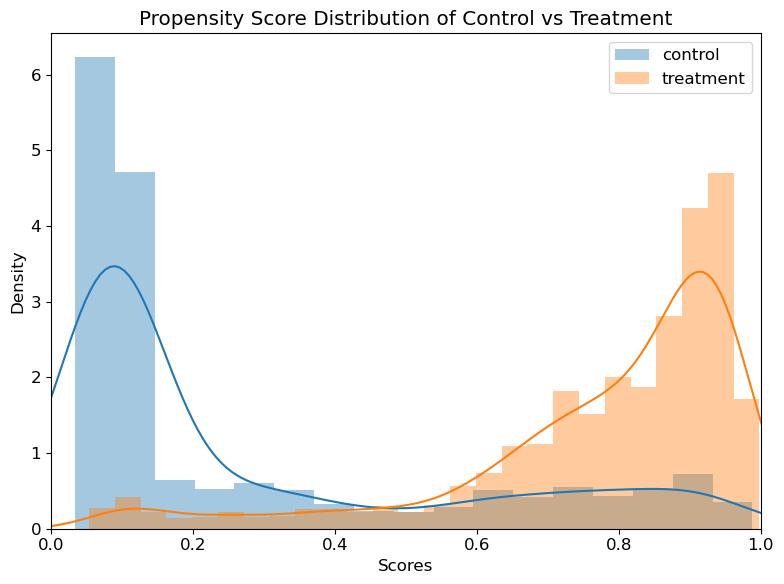

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

ax = sns.distplot(neg_pscore, label='control')
ax = sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Provedeme matching.

In [0]:
from sklearn.neighbors import NearestNeighbors

def get_similar(pos_score: np.ndarray, neg_score: np.ndarray, topn: int=5, n_jobs: int=1):
    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_score.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_score.reshape(-1, 1))
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    return distances, indices

In [0]:
_, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[633],
       [249],
       [293],
       ...,
       [361],
       [ 96],
       [949]])

In [0]:
df_cleaned[TREATMENT] = treatment
df_cleaned[NIHSS_DISCHARGE] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,sex,heightvalue,weight,involvedVascularTerritorryArterior,involvedVascularTerritorryLeft,involvedVascularTerritorryPosterior,involvedVascularTerritorryRight,atrialFibrilation,congestiveHeartFailure,diabetes,hyperlipidemia,hypertension,previousStrokeEarlierThan3M,previousStrokeWithin3M,previousTIAOrAmaurosis,smokerCurrent,smokerPrevious,vascularDisease,treatment,NIHSS-diff-discharge
1,57.0,0.0,1.0,89.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-4.0
2,72.0,1.0,0.0,77.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,-6.0
3,86.0,0.0,0.0,55.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
4,63.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
7,40.0,1.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [0]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.1480
1,sex,0.1283
2,heightvalue,0.0350
3,weight,0.2286
4,involvedVascularTerritorryArterior,0.2505
5,involvedVascularTerritorryLeft,0.2934
6,involvedVascularTerritorryPosterior,0.0950
7,involvedVascularTerritorryRight,0.0652
8,atrialFibrilation,0.0313
9,congestiveHeartFailure,0.0095


In [0]:
from scipy.stats import stats

num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[NIHSS_DISCHARGE].values, df_neg[NIHSS_DISCHARGE].values)

number of matched pairs:  1578


Ttest_relResult(statistic=-7.990912558844512, pvalue=2.563586277408815e-15)